In [1]:
import os
import glob
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, hamming_loss,confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize


import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

In [2]:
## data-augmentation pipline

pathToDataset = r"E:\Rice_Image_Dataset\Rice_Image_Dataset"
batchSize = 32
imgSize = (160,160)

train_dataset = image_dataset_from_directory(
    pathToDataset,
    shuffle = True,
    batch_size = batchSize,
    image_size = imgSize,
    validation_split = 0.2,
    subset = 'training',
    seed = 42
)

test_dataset = image_dataset_from_directory(
    pathToDataset,
    shuffle = True,
    batch_size = batchSize,
    image_size = imgSize,
    validation_split = 0.2,
    subset = 'validation',
    seed = 42
)

num_classes = 5
class_names = train_dataset.class_names

Found 75000 files belonging to 5 classes.
Using 60000 files for training.
Found 75000 files belonging to 5 classes.
Using 15000 files for validation.


In [3]:
#one-hot-encoding for further use
def one_hot_encode(images, labels):
    labels = tf.one_hot(labels, depth=num_classes)
    return images, labels

train_dataset = train_dataset.map(one_hot_encode)
test_dataset = test_dataset.map(one_hot_encode)

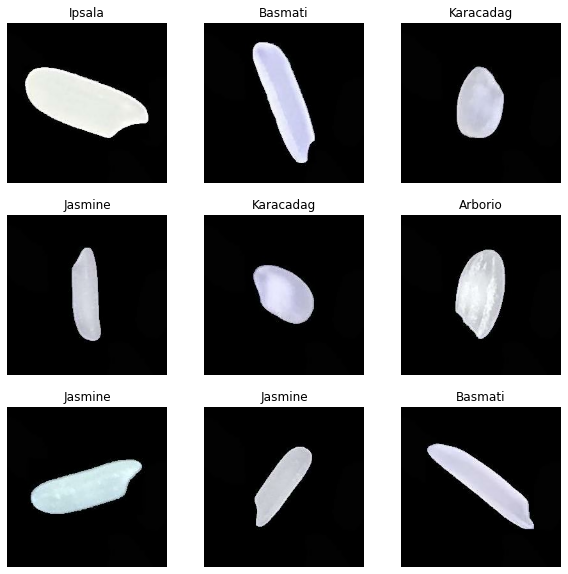

In [4]:
#display of raw images from directory
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"{class_names[np.where(labels[i].numpy().astype(bool))[0][0]]}")
        plt.axis("off")

In [5]:
## data-augmentation pipeline

data_augmenter = tf.keras.Sequential([
    tfl.RandomFlip('horizontal'),
    tfl.RandomRotation(0.2),

    tfl.RandomBrightness(0.2),
    tfl.RandomContrast(0.2)
])

In [6]:
# caching and pre-fetching enabled

AUTOTUNE = tf.data.AUTOTUNE

train_dataset_prefetched = (
    train_dataset
    .shuffle(1000)
    .map(lambda x,y : (data_augmenter(x, training=True),y), num_parallel_calls = AUTOTUNE)
    .cache()
    .prefetch(buffer_size = AUTOTUNE)
)

test_dataset_prefetched = (
    test_dataset
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

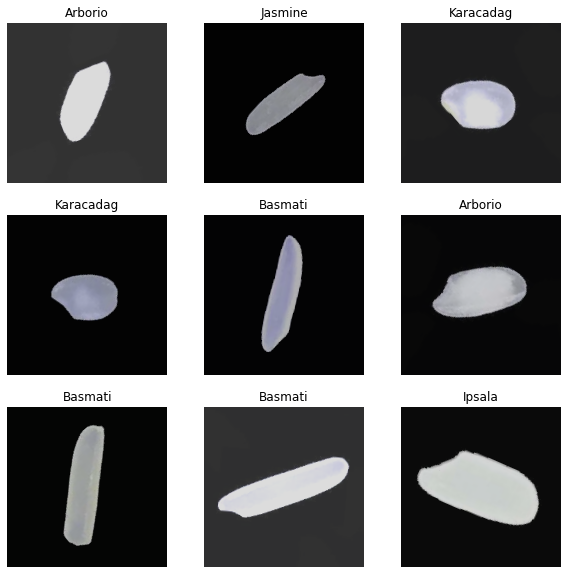

In [7]:
#display after data-augmentation

for images, labels in train_dataset_prefetched.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        plt.title(f"{class_names[np.where(labels[i].numpy().astype(bool))[0][0]]}")
        plt.axis("off")

In [8]:
## using mobilenet-v2

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [9]:
#loading and analysing model-weights and architecture of mobile-net-v2 with top layers for (160,160,3) inputs
imgSize = imgSize + (3,)

base_model_path = 'with_top_mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_160.h5'

base_model_mn2 = tf.keras.applications.MobileNetV2(
    input_shape = imgSize,
    include_top = True,
    weights = base_model_path
)

In [10]:
base_model_mn2.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

 block_3_expand_relu (ReLU)  (None, 40, 40, 144)          0         ['block_3_expand_BN[0][0]']   
                                                                                                  
 block_3_pad (ZeroPadding2D  (None, 41, 41, 144)          0         ['block_3_expand_relu[0][0]'] 
 )                                                                                                
                                                                                                  
 block_3_depthwise (Depthwi  (None, 20, 20, 144)          1296      ['block_3_pad[0][0]']         
 seConv2D)                                                                                        
                                                                                                  
 block_3_depthwise_BN (Batc  (None, 20, 20, 144)          576       ['block_3_depthwise[0][0]']   
 hNormalization)                                                                                  
          

 block_6_depthwise_BN (Batc  (None, 10, 10, 192)          768       ['block_6_depthwise[0][0]']   
 hNormalization)                                                                                  
                                                                                                  
 block_6_depthwise_relu (Re  (None, 10, 10, 192)          0         ['block_6_depthwise_BN[0][0]']
 LU)                                                                                              
                                                                                                  
 block_6_project (Conv2D)    (None, 10, 10, 64)           12288     ['block_6_depthwise_relu[0][0]
                                                                    ']                            
                                                                                                  
 block_6_project_BN (BatchN  (None, 10, 10, 64)           256       ['block_6_project[0][0]']     
 ormalizat

                                                                                                  
 block_9_add (Add)           (None, 10, 10, 64)           0         ['block_8_add[0][0]',         
                                                                     'block_9_project_BN[0][0]']  
                                                                                                  
 block_10_expand (Conv2D)    (None, 10, 10, 384)          24576     ['block_9_add[0][0]']         
                                                                                                  
 block_10_expand_BN (BatchN  (None, 10, 10, 384)          1536      ['block_10_expand[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 block_10_expand_relu (ReLU  (None, 10, 10, 384)          0         ['block_10_expand_BN[0][0]']  
 )        

                                                                                                  
 block_13_expand_relu (ReLU  (None, 10, 10, 576)          0         ['block_13_expand_BN[0][0]']  
 )                                                                                                
                                                                                                  
 block_13_pad (ZeroPadding2  (None, 11, 11, 576)          0         ['block_13_expand_relu[0][0]']
 D)                                                                                               
                                                                                                  
 block_13_depthwise (Depthw  (None, 5, 5, 576)            5184      ['block_13_pad[0][0]']        
 iseConv2D)                                                                                       
                                                                                                  
 block_13_

 iseConv2D)                                                                                       
                                                                                                  
 block_16_depthwise_BN (Bat  (None, 5, 5, 960)            3840      ['block_16_depthwise[0][0]']  
 chNormalization)                                                                                 
                                                                                                  
 block_16_depthwise_relu (R  (None, 5, 5, 960)            0         ['block_16_depthwise_BN[0][0]'
 eLU)                                                               ]                             
                                                                                                  
 block_16_project (Conv2D)   (None, 5, 5, 320)            307200    ['block_16_depthwise_relu[0][0
                                                                    ]']                           
          

In [11]:
nb_layers = len(base_model_mn2.layers)
print(f'Total Number of Layers : {nb_layers}\n')
print('Last two layers responsible for classification : ')
print(base_model_mn2.layers[nb_layers - 2].name)
print(base_model_mn2.layers[nb_layers - 1].name)

Total Number of Layers : 156

Last two layers responsible for classification : 
global_average_pooling2d
predictions


In [12]:
## run0

base_model_path = 'without_top_mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_160_no_top.h5'

base_model_mn2 = tf.keras.applications.MobileNetV2(
    input_shape = imgSize,
    include_top = False,
    weights = base_model_path
)

#freeze the base-model during training
base_model_mn2.trainable = False

#using functional-API of tensorflow

input_layer = tfl.Input(shape=imgSize)
#pre-process according to the mobilenet-v2 preprocessed weights
x = preprocess_input(input_layer)
#pass it to base-model
x = base_model_mn2(x,training=False)


#adding top2 classification layers
x = tfl.GlobalAvgPool2D()(x)
#include dropout with 0.2 probability to avoid overfitting
x = tfl.Dropout(0.2)(x)

#defining output-layers with 5 neurons and softmax activation-function
outputs = tfl.Dense(5,activation='softmax')(x)

model1 = tf.keras.Model(input_layer,outputs)



In [13]:
model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 160, 160, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 160, 160, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                   

In [15]:
model1_learning_rate = 1e-3

model1.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
             optimizer=tf.keras.optimizers.Adam(learning_rate=model1_learning_rate),
             metrics=['accuracy'])



In [16]:
history_model1 = model1.fit(train_dataset_prefetched,validation_data=test_dataset_prefetched,epochs=5)

Epoch 1/5
1875/1875 [==============================] - 1160s 562ms/step - loss: 0.1222 - accuracy: 0.9592 - val_loss: 0.0621 - val_accuracy: 0.9811
Epoch 2/5
1875/1875 [==============================] - 947s 505ms/step - loss: 0.0615 - accuracy: 0.9792 - val_loss: 0.0571 - val_accuracy: 0.9810
Epoch 3/5
1875/1875 [==============================] - 898s 479ms/step - loss: 0.0549 - accuracy: 0.9811 - val_loss: 0.0563 - val_accuracy: 0.9817
Epoch 4/5
1875/1875 [==============================] - 911s 486ms/step - loss: 0.0517 - accuracy: 0.9821 - val_loss: 0.0475 - val_accuracy: 0.9856
Epoch 5/5
1875/1875 [==============================] - 932s 497ms/step - loss: 0.0514 - accuracy: 0.9821 - val_loss: 0.0488 - val_accuracy: 0.9837


In [17]:
def plot_history(history):
    
    acc = [0.] + history.history['accuracy']
    val_acc = [0.] + history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy',linestyle='--')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.ylim([min(plt.ylim()),1.1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss',)
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([min(min(loss),min(val_loss)),max(max(loss),max(val_loss))])
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.tight_layout()
    plt.show()
    

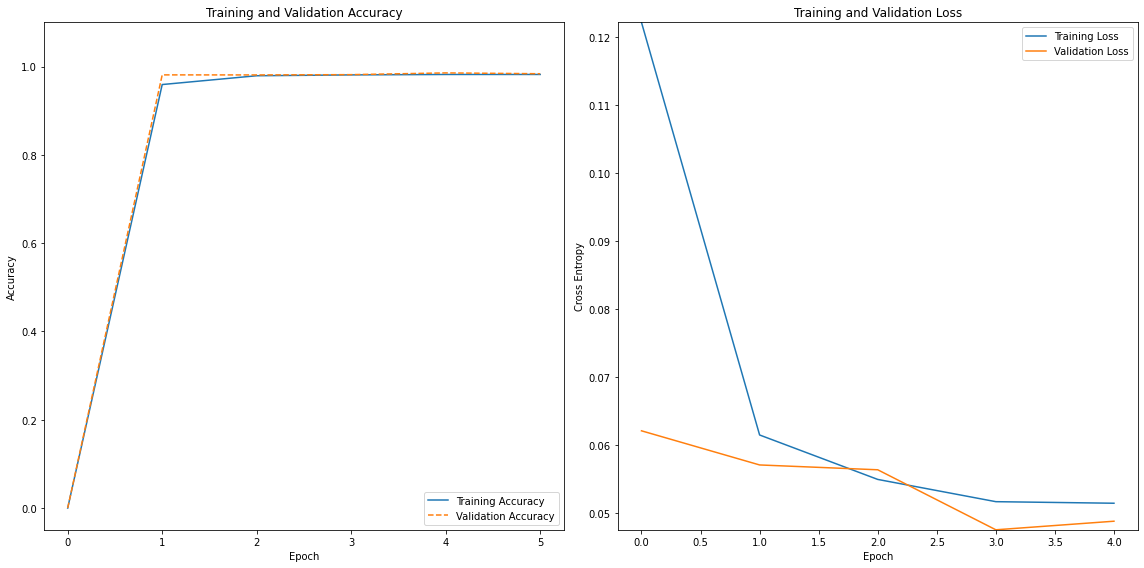

In [18]:
plot_history(history_model1)

In [19]:
model1.save('model1.keras')

In [20]:
model1.evaluate(test_dataset_prefetched)

469/469 [==============================] - 207s 440ms/step - loss: 0.0488 - accuracy: 0.9837


[0.04878266900777817, 0.9837333559989929]

In [25]:
model1_preds = model1.predict(test_dataset_prefetched)

469/469 [==============================] - 177s 378ms/step


In [27]:
model1_preds.shape

(15000, 5)

In [125]:
Ypred = [np.argmax(i) for i in model1_preds]
Ytrue = []
for images,labels in test_dataset_prefetched:
    Ytrue.extend(np.argmax(labels.numpy(),axis=1))
    
np.save('raw-yscores_model1.npy',model1_preds)
np.save('Ytrue.npy',Ytrue)
np.save('Ypred_model1.npy',Ypred)

In [123]:
accuracy = accuracy_score(Ytrue,Ypred)
precision = precision_score(Ytrue,Ypred,average='weighted')
recall = recall_score(Ytrue,Ypred,average='weighted')
f1 = f1_score(Ytrue,Ypred,average='weighted')
hamming = hamming_loss(Ytrue, Ypred)



print(f'Accuracy on Test-Data :: {accuracy : .4f}')
print(f'Precision on Test-Data :: {precision : .4f}')
print(f'Recall on Test-Data :: {recall : .4f}')
print(f'F1-Score on Test-Data :: {f1 : .4f}')
print(f'Hamming-Loss on Test-Data :: {hamming : .4f}')

Accuracy on Test-Data ::  0.9837
Precision on Test-Data ::  0.9842
Recall on Test-Data ::  0.9837
F1-Score on Test-Data ::  0.9838
Hamming-Loss on Test-Data ::  0.0163


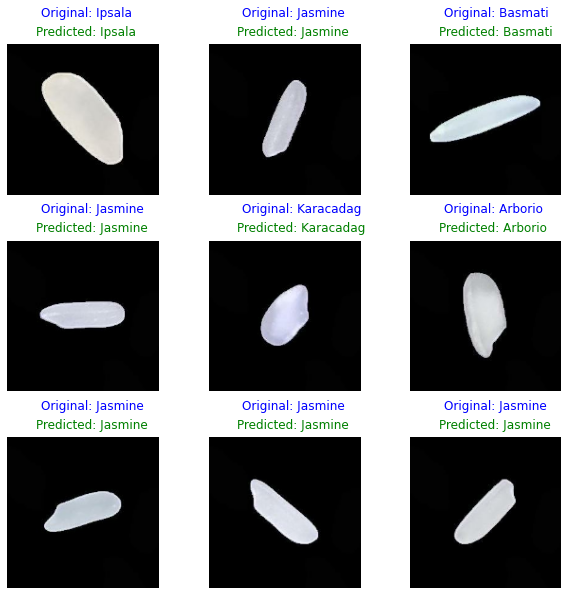

In [98]:
takeidx = 1
for images, labels in test_dataset_prefetched.take(takeidx):
    fig,axs = plt.subplots(3,3,figsize=(10, 10))
    axs = axs.flatten()
    for i in range(9):
        axs[i].imshow(images[i].numpy().astype("uint8"))
        
        axs[i].axis("off")
        if class_names[Ypred[i]] == class_names[Ytrue[i]]:
            axs[i].text(30, -10, f"Predicted: {class_names[Ypred[i]]}", color='green', fontsize=12)
        else:
            axs[i].text(30, -10, f"Predicted: {class_names[Ypred[i]]}", color='red', fontsize=12)
        axs[i].text(35, -30, f"Original: {class_names[Ytrue[i]]}", color='blue', fontsize=12)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

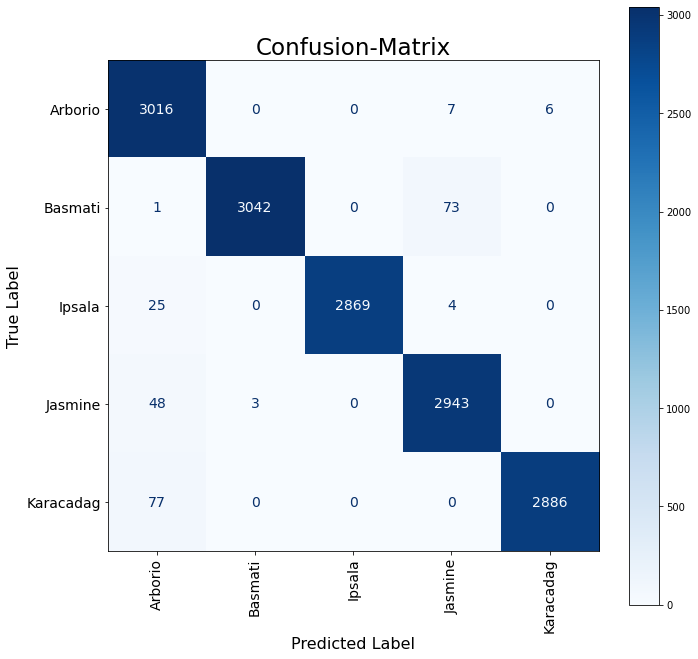

In [118]:
cm = confusion_matrix(Ytrue, Ypred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names,)
plt.figure(figsize=(11,11))
disp.plot(cmap=plt.cm.Blues, ax=plt.gca(),text_kw={'fontsize':14})
plt.title('Confusion-Matrix',fontsize=23)
plt.xlabel('Predicted Label',fontsize=16)
plt.ylabel('True Label',fontsize=16)
plt.xticks(rotation=90,fontsize=14)
plt.yticks(fontsize=14)
plt.show()

# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
# plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion Matrix')
# plt.show()

In [122]:

print(classification_report(Ytrue, Ypred,target_names=class_names))

              precision    recall  f1-score   support

     Arborio       0.95      1.00      0.97      3029
     Basmati       1.00      0.98      0.99      3116
      Ipsala       1.00      0.99      0.99      2898
     Jasmine       0.97      0.98      0.98      2994
   Karacadag       1.00      0.97      0.99      2963

    accuracy                           0.98     15000
   macro avg       0.98      0.98      0.98     15000
weighted avg       0.98      0.98      0.98     15000



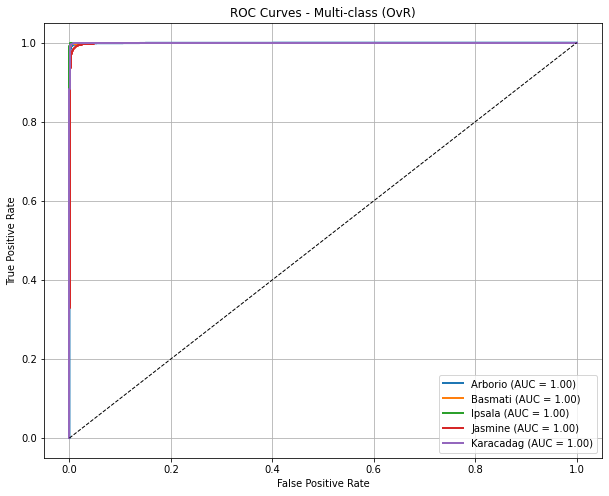

In [134]:
n_classes = len(class_names)
Ytrue_bin = label_binarize(Ytrue, classes=range(n_classes))

fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Ytrue_bin[:, i], model1_preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Multi-class (OvR)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()



